<a href="https://colab.research.google.com/github/solomonaboyeji/data-science-course-work/blob/main/Chapter_7_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (289/289), done.
remote: Total 526 (delta 251), reused 481 (delta 231), pack-reused 0
Receiving objects: 100% (526/526), 29.30 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (251/251), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
!pip install farm-haystack[colab]==1.4.0
!pip install matplotlib
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.7/524.7 kB 8.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of farm-haystack[colab] to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<1.11,>1.9 (from farm-haystack[colab]) (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0)
ERROR: No matching distribution found for torch<1.11,>1.9


In [ ]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

Downloading:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name='electronics')


Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
subjqa['train']['answers'][1]

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

In [ ]:
import pandas as pd

dfs = { split: dset.to_pandas() for split, dset in subjqa.flatten().items() }

for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [ ]:
qa_cols = ['title', 'question', 'answers.text', 'answers.answer_start', 'context']
sample_df = dfs['train'][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [ ]:
start_idx = sample_df['answers.answer_start'].iloc[0][0]
end_idx = start_idx + len(sample_df['answers.text'].iloc[0][0])
sample_df['context'].iloc[0][start_idx:end_idx]

'this keyboard is compact'

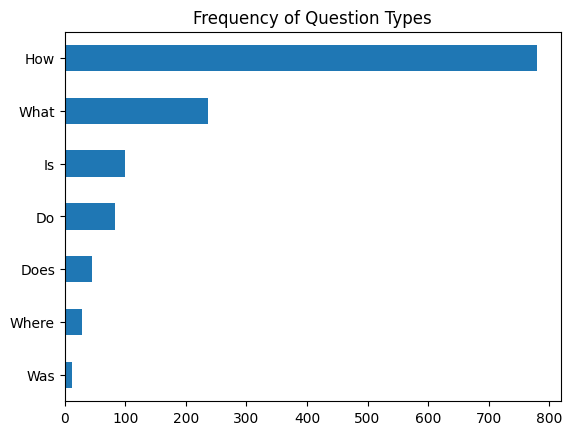

In [ ]:
import matplotlib.pyplot as plt
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Where"]

for q in question_types:
  counts[q] = dfs['train']['question'].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [ ]:
for question_type in ['How', 'What', 'Is']:
  for question in (dfs['train'][dfs['train'].question.str.startswith(question_type)].sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


# Using a fine-tuned model for a QA Task (Manually)

In [ ]:
# get a model that has been trained on the. SQUAD dataset, fast and would run on CPU if you will.
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Tokenize the question and the answer
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size"""
inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
inputs # 1 for context, 0 for question , not all models have the token_type_ids

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

In [ ]:
# we can decode it back to see how the model is viewing it.
# [CLS] Question [SEP] Context [SEP]
print(tokenizer.decode(inputs['input_ids'][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size [SEP]


## Instantiate the model with a QA Head

We treat QA has a form of token classication, we use the hidden layers from the fine-tuned model and pass it through our QA Head

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs = model(**inputs)

print(outputs)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9579, -4.7099, -5.3564, -5.1209, -5.2379, -5.4165, -4.9024, -6.1205,
         -0.9579, -0.3564, -0.3229, -1.7046,  3.7663,  5.0313, -0.9348, -3.8593,
         -1.6140, -4.2240, -1.4083,  3.9432,  5.0287, -0.1064, -3.1841, -4.7811,
         -2.2432, -3.0618, -0.9579]]), end_logits=tensor([[-0.9874, -5.3772, -4.9772, -5.0612, -5.4099, -5.3422, -5.0853, -4.4537,
         -0.9874, -3.6618, -0.8209, -3.6625, -3.0288, -1.0779,  0.4735, -2.5397,
          5.0106, -0.6661, -2.9796, -3.3489,  0.6373,  5.6044, -0.2637, -4.7080,
         -2.2587,  0.7653, -0.9874]]), hidden_states=None, attentions=None)


In [ ]:
# start_logits and end_logits represents the beginning and the end of our answers
start_logits = outputs.start_logits
end_logits = outputs.end_logits


start_logits, end_logits


# print(f"Input IDs shape: {inputs.input_ids.size()}")
# print(f"Start IDs shape: {start_logits.size()}")
# print(f"End IDs shape: {end_logits.size()}")

(tensor([[-0.9579, -4.7099, -5.3564, -5.1209, -5.2379, -5.4165, -4.9024, -6.1205,
          -0.9579, -0.3564, -0.3229, -1.7046,  3.7663,  5.0313, -0.9348, -3.8593,
          -1.6140, -4.2240, -1.4083,  3.9432,  5.0287, -0.1064, -3.1841, -4.7811,
          -2.2432, -3.0618, -0.9579]]),
 tensor([[-0.9874, -5.3772, -4.9772, -5.0612, -5.4099, -5.3422, -5.0853, -4.4537,
          -0.9874, -3.6618, -0.8209, -3.6625, -3.0288, -1.0779,  0.4735, -2.5397,
           5.0106, -0.6661, -2.9796, -3.3489,  0.6373,  5.6044, -0.2637, -4.7080,
          -2.2587,  0.7653, -0.9874]]))

In [ ]:
# to get the final answer, we compute the argmax over the start and the end tokens logits and then slice the span form the inputs.

import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs['input_ids'][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")


print(start_idx, end_idx)

Question: How much music can this hold?
Answer: 1 mb / minute, so about 6000 hours
tensor(13) tensor(22)


In [ ]:
# No answer: If there is no answer, this QA head should assign the highest score the CLS token, indicating no answer
# Tokenize the question and the answer
question = "Why is there no data?"
inputs = tokenizer(question, context, return_tensors="pt")
# how the model is seeing it
# print(tokenizer.decode(inputs['input_ids'][0]))

with torch.no_grad():
  outputs = model(**inputs)

print("CLS token at the start of start_logits and end_logits will have the high/highest score")
print(outputs)

print("\n\n")

start_logits = outputs.start_logits
end_logits = outputs.end_logits

cls_start_score = start_logits[0][0]
cls_end_score = end_logits[0][0]


print(cls_start_score, cls_end_score, start_logits.max(), end_logits.max() )
print(cls_start_score >= start_logits.max())
print(cls_end_score >= end_logits.max())

# We had to introduce a threshold to achieve this?
threshold = 1e-5
if (cls_start_score + threshold >= start_logits.max()) and (cls_end_score + threshold >= end_logits.max()):
    print("No Answer2")

if (cls_start_score >= start_logits.max()) and (cls_end_score >= end_logits.max()):
  print("No Answer3")

# cls_start_score = start_logits[0][cls_token_id]
# cls_end_score = end_logits[0][cls_token_id]
# cls_start_score, cls_end_score

# start_logits, end_logits

# start_idx = torch.argmax(start_logits)
# end_idx = torch.argmax(end_logits) + 1

# print(start_idx, end_idx)

# answer_span = inputs['input_ids'][0][start_idx:end_idx]
# answer = tokenizer.decode(answer_span)

# print(f"Question: {question}")
# print(f"Answer: {answer}")

CLS token at the start of start_logits and end_logits will have the high/highest score
QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 3.2141, -5.0445, -5.5764, -5.4740, -5.0612, -5.9309, -6.3960,  3.2141,
         -0.8482, -1.3006, -3.2371, -0.4201, -0.2632, -3.2060, -4.7691, -3.5787,
         -5.1083, -2.9553, -1.1188, -0.6310, -2.4848, -2.8068, -3.5480, -1.3323,
         -2.3931,  3.2141]]), end_logits=tensor([[ 3.4479, -5.3212, -5.6856, -5.5271, -5.3995, -5.3546, -4.9222,  3.4478,
         -5.0451, -1.4860, -5.0636, -5.0296, -3.5689, -3.2704, -5.8026, -0.9703,
         -1.6635, -4.4168, -5.6983, -2.9167, -0.3880, -3.5611, -5.8173, -3.0545,
          0.1193,  3.4479]]), hidden_states=None, attentions=None)



tensor(3.2141) tensor(3.4479) tensor(3.2141) tensor(3.4479)
tensor(True)
tensor(False)
No Answer2


# Replacing all of this with HuggingFace API

In [ ]:
from transformers import pipeline

pipe = pipeline('question-answering', model=model, tokenizer=tokenizer)
# top_k allows to get multipl answers from the model
pipe(question=question, context=context, top_k=3)


[{'score': 0.0008844999829307199,
  'start': 16,
  'end': 71,
  'answer': '1 MB/minute, so about 6000 hours depending on file size'},
 {'score': 0.000756103778257966,
  'start': 10,
  'end': 71,
  'answer': 'about 1 MB/minute, so about 6000 hours depending on file size'},
 {'score': 0.000612312403973192,
  'start': 38,
  'end': 71,
  'answer': '6000 hours depending on file size'}]

In [ ]:
# Handle situation where there is no answer
# The pipeline has mapped out the highest token to th CLS as empty string
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.7988590598106384, 'start': 0, 'end': 0, 'answer': ''}

# Dealing with Long Passages

In [ ]:
# Creating a sliding window
example = dfs['train'].iloc[0][['question', 'context']]
tokenized_example = tokenizer(example['question'], example['context'], return_overflowing_tokens=True, max_length=100, stride=23)

for idx, window in enumerate(tokenized_example['input_ids']):
  print(f"Window #{idx} has {len(window)} tokens")

# Viewing where 2 windows over lap
for window in tokenized_example['input_ids']:
  print(f"{tokenizer.decode(window)} \n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Window #0 has 100 tokens
Window #1 has 86 tokens
[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



## Building Haystack to Build a QA Pipeline

2 Main Components: Retriever and Reader. Reader are usually comprises of a reading comprehension model, however other kind of models can be used to generate free text form.